# Prática de Aceleração e Eficiência

Este caderno experimental tem por objetivo calcularmos a aceleração (*speedup*) e eficiência de uma operação quando esta pode ser calculada em paralelo. Utilizaremos como exemplo uma operação que consiste em multiplicar duas matrizes.

Empregaremos as bibliotecas `numpy` para lidar com os valores e organização dos dados e `dask` para a paralelização da operação.



## Instalação de pacotes

In [46]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install dask[distributed]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 11.0 MB/s eta 0:00:00m eta 0:00:010:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.5 MB/s eta 0:00:00m eta 0:00:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 960.8/960.8 kB 10.9 MB/s eta 0:00:00 MB/s eta 0:00:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.9/295.9 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 10.4 MB/s eta 0:00:00m eta 0:00:010:01:01


## Multiplicação de matriz sequencial (`numpy`)



### Carga das bibliotecas necessárias

In [2]:
# setar variáeis de ambiente para execução sequencial
import os
os.environ["MKL_NUM_THREADS"] = "1" 
os.environ["OMP_NUM_THREADS"] = "1" 
# numpy para gerenciar dados
import numpy as np
# timeit para medir o tempo
from timeit import default_timer as timer

### Criação das matrizes com valores aleatórios

Criamos a matriz A com as dimensões especificadas na chamada.

In [3]:
# reshape: -1 = sem definição de linhas, 8000 = quantidade de colunas
A = np.random.rand(48000000).reshape(-1, 8000)
A

array([[0.85015036, 0.18309851, 0.63670515, ..., 0.07482443, 0.62346928,
        0.95011652],
       [0.1941551 , 0.99347785, 0.86127041, ..., 0.98970753, 0.06638186,
        0.58360955],
       [0.64003241, 0.84128334, 0.18036577, ..., 0.36872586, 0.04910144,
        0.09317597],
       ...,
       [0.79895833, 0.93950652, 0.2536955 , ..., 0.95779086, 0.64172049,
        0.31437653],
       [0.1301509 , 0.16212672, 0.00555235, ..., 0.69229724, 0.24976511,
        0.26902971],
       [0.00734595, 0.82487426, 0.52638208, ..., 0.31526602, 0.61569296,
        0.39283807]])

Criamos a matriz B.
- A primeira dimensão de B deve ser igual à segunda dimensão de A para que a operação de múltiplicação seja possível.

In [4]:
B = np.random.rand(48000000).reshape(8000, -1)
B

array([[0.10443018, 0.11708437, 0.20954629, ..., 0.80304561, 0.75292317,
        0.17769305],
       [0.38059119, 0.35803032, 0.49979193, ..., 0.86173493, 0.74510067,
        0.89016187],
       [0.10178359, 0.12242471, 0.96387693, ..., 0.92086467, 0.55949042,
        0.71735677],
       ...,
       [0.00613916, 0.59509134, 0.72476816, ..., 0.65909961, 0.51967828,
        0.82132617],
       [0.2422428 , 0.95961372, 0.04107329, ..., 0.46929137, 0.42631033,
        0.08909182],
       [0.69011613, 0.64476608, 0.50880262, ..., 0.88114454, 0.57709735,
        0.06796289]])

### Lançamos a multiplicação

Realizamos a multiplicação de matriz e medimos o tempo de execução.

In [5]:
start = timer()
C = np.matmul(A, B)
end = timer()
print(end - start)

21.21504428400658


Podemos observar acima o tempo que levou para realizar esta multiplicação de matrizes de maneira sequencial.

## Multiplicação de matriz sequencial (`numpy` e `dask`)


In [6]:
import dask.array as da

In [7]:
dA = da.from_array(A, chunks=(6000,8000))
dA


dask.array<array, shape=(6000, 8000), dtype=float64, chunksize=(6000, 8000), chunktype=numpy.ndarray>

In [8]:
dB = da.from_array(B, chunks=(8000,6000))
dB

dask.array<array, shape=(8000, 6000), dtype=float64, chunksize=(8000, 6000), chunktype=numpy.ndarray>

In [9]:
start = timer()
dC = da.matmul(dA, dB).compute()
end = timer()
print(end-start)

12.531170914997347


## Multiplicação de matriz com paralelismo (`numpy` e `dask`)




In [40]:
import dask.array as da
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers = 2, threads_per_worker = 1)
client = Client(cluster)

/home/s113650157/Dev/miniconda3/envs/cd009/lib/python3.10/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33083 instead
  warnings.warn(


In [11]:
cluster.scheduler

<Scheduler 'tcp://127.0.0.1:34075', workers: 2, cores: 2, tasks: 0>

In [12]:
cluster.workers

{0: <Nanny: tcp://127.0.0.1:42759, threads: 1>,
 1: <Nanny: tcp://127.0.0.1:33025, threads: 1>}

In [13]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 14.89 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34075,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 14.89 GiB
Comm: tcp://127.0.0.1:42759,Total threads: 1
Dashboard: http://127.0.0.1:43427/status,Memory: 7.44 GiB
Nanny: tcp://127.0.0.1:33255,


In [14]:
# dA = da.from_array(A) #, chunks=(8000, -1))
dA = da.from_array(A , chunks=(3000, -1))
dA

dask.array<array, shape=(6000, 8000), dtype=float64, chunksize=(3000, 8000), chunktype=numpy.ndarray>

In [15]:
dB = da.from_array(B) #, chunks=(-1, 8000))
dB = da.from_array(B , chunks=(-1, 3000))
dB

dask.array<array, shape=(8000, 6000), dtype=float64, chunksize=(8000, 3000), chunktype=numpy.ndarray>

In [16]:
dC = da.matmul(dA, dB)

In [17]:
dC.visualize()

RuntimeError: No visualization engine detected, please install graphviz or ipycytoscape

In [18]:
start = timer()
dC.compute()
end = timer()
print(end-start)

14.129324588022428


## Calculando Aceleração e Eficiência

Vamos agora dimensionar o cluster local para que a quantidade de processos trabalhadores mude de 1 (execução que pode ser considerada sequencial) até uma determinada quantidade de trabalhadores. Vamos coletar os tempos de execução de cada execução e calcular a aceleração e eficiência. Os dados serão salvos em um arquivo CSV `experimento.csv` para que possamos analisá-los posteriormente.

In [41]:
import csv
csv_header = ["p", "time"]
with open('experimento.csv', 'w') as file:
  writer = csv.writer(file)
  writer.writerow(["p", "time"]) # o cabeçalho do CSV
  for p in range(1, 10):
#   for p in [1, 2, 3, 4, 5]:
    # Vamos configurar o tamanho do cluster
    cluster.scale(p)
    # Vamos executar o experimento
    start = timer()
    dC.compute()
    end = timer()
    # Salvar no arquivo CSV a tupla
    writer.writerow([p, end - start])



Vamos ver o conteúdo do arquivo com as medidas de desempenho

In [42]:
!cat experimento.csv

In [43]:
import pandas as pd
df = pd.read_csv('experimento.csv')
print(df.to_string()) 

   p       time
0  1  19.376347
1  2  14.081433
2  3  13.473338
3  4  12.904201
4  5  12.153793
5  6  12.032799
6  7  12.192362
7  8   9.910392
8  9   9.324121


In [44]:
tseq = df.query('p == 1')['time'].iloc[0]
tseq
df = df.assign(seq = tseq)
df = df.assign(speedup = df['seq']/df['time'])
df = df.assign(eficiencia = df['speedup']/df['p'])
df

,p,time,seq,speedup,eficiencia
0,1,19.376347,19.376347,1.000000,1.000000
1,2,14.081433,19.376347,1.376021,0.688010
2,3,13.473338,19.376347,1.438125,0.479375
3,4,12.904201,19.376347,1.501553,0.375388
4,5,12.153793,19.376347,1.594263,0.318853
5,6,12.032799,19.376347,1.610294,0.268382
6,7,12.192362,19.376347,1.589220,0.227031
7,8,9.910392,19.376347,1.955155,0.244394
8,9,9.324121,19.376347,2.078088,0.230899


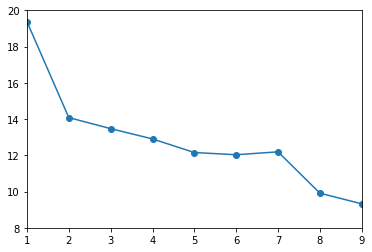

In [56]:
import matplotlib.pyplot as plt
variable = 'speedup'
plt.scatter(df['p'], df[variable])
plt.plot(df['p'], df[variable])
plt.axvline(x=0, c="black", label="x=0")
plt.axhline(y=0, c="black", label="y=0")
plt.xlim([1, 9])
plt.ylim([8, 20])
plt.show()


A interpretação do gráfico nos permite delinear conclusões interessantes sobre a paralelização tanto do ponto de vista do software quanto do hardware. Outros elementos que podem influenciar o desempenho incluem o tamanho e a quantidade de chunks.

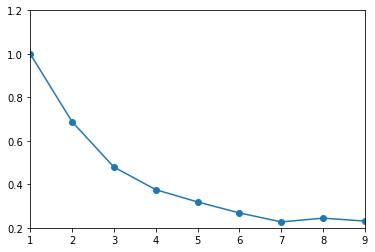

In [57]:
import matplotlib.pyplot as plt
variable = 'eficiencia'
plt.scatter(df['p'], df[variable])
plt.plot(df['p'], df[variable])
plt.axvline(x=0, c="black", label="x=0")
plt.axhline(y=0, c="black", label="y=0")
plt.xlim([1, 9])
plt.ylim([0.2, 1.2])
plt.show()